In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [263]:
dr14 = pd.read_csv('Dataset/SDSS_DR14.csv')
dr16 = pd.read_csv('Dataset/SDSS_DR16.csv')
dr17 = pd.read_csv('Dataset/SDSS_DR17.csv')
dr18 = pd.read_csv('Dataset/SDSS_DR18.csv') 
dataframe = pd.concat([dr14, dr16, dr17, dr18], ignore_index=True, sort=False)

In [264]:
df = dataframe.dropna(axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      310000 non-null  object 
 1   ra         310000 non-null  float64
 2   dec        310000 non-null  float64
 3   u          310000 non-null  float64
 4   g          310000 non-null  float64
 5   r          310000 non-null  float64
 6   i          310000 non-null  float64
 7   z          310000 non-null  float64
 8   run        310000 non-null  int64  
 9   rerun      310000 non-null  int64  
 10  camcol     310000 non-null  int64  
 11  field      310000 non-null  int64  
 12  specobjid  310000 non-null  object 
 13  class      310000 non-null  object 
 14  redshift   310000 non-null  float64
 15  plate      310000 non-null  int64  
 16  mjd        310000 non-null  int64  
 17  fiberid    310000 non-null  int64  
dtypes: float64(8), int64(7), object(3)
memory usage: 42.6+ MB


I need to get rid of values that are not correlated in any way to our class - those are going to be technical informations about observatory, ID numbers etc


In [265]:
df=df.drop(columns=['objid','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'])

Dodatkowo pozbędziemy się fałszywych danych poza zakresami 

In [266]:
df.describe()

,ra,dec,u,g,r,i,z,redshift
count,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000
mean,174.694084,22.097973,19.716598,18.413805,17.770995,17.382543,17.075167,0.300031
std,85.593731,22.738541,18.124083,18.109926,1.907456,18.081449,36.024479,0.579806
min,0.003092,-19.495456,-9999.000000,-9999.000000,9.005167,-9999.000000,-9999.000000,-0.009971
25%,131.354822,1.042457,18.510617,17.143935,16.472307,16.136660,15.908515,0.000107
50%,175.860912,17.145758,19.184505,17.904820,17.357705,17.063675,16.893270,0.070177
75%,223.633481,41.176901,20.162707,19.213520,18.882188,18.631750,18.436143,0.279405
max,359.999810,84.490494,32.781390,31.602240,31.990100,32.141470,29.383740,7.011245


In [268]:
df['class'].describe()

count     310000
unique         3
top       GALAXY
freq      168109
Name: class, dtype: object

In [269]:
pd.set_option('future.no_silent_downcasting', True)
uniques = pd.unique(df['class'])
binary_map = {}
for number, value in enumerate(uniques):
    binary_map[value] = number
df['class'] = df['class'].replace(binary_map)
binary_map

{'STAR': 0, 'GALAXY': 1, 'QSO': 2}

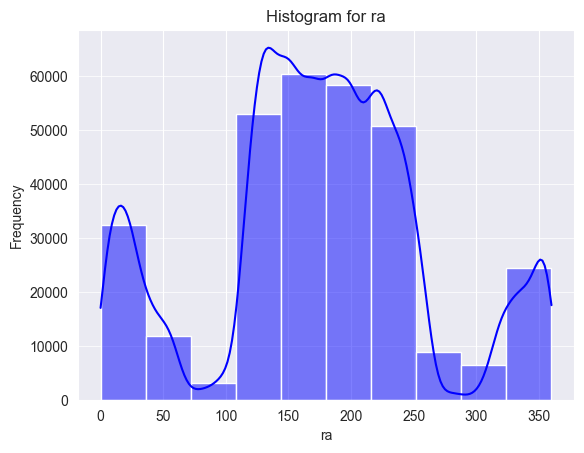

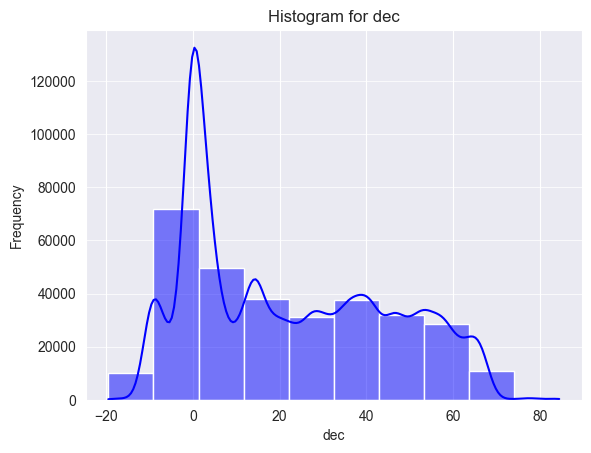

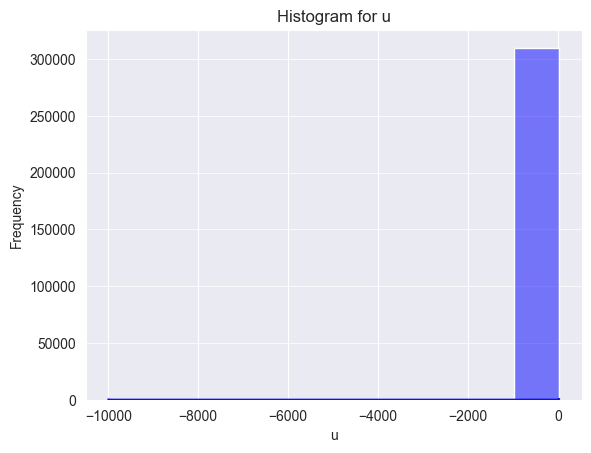

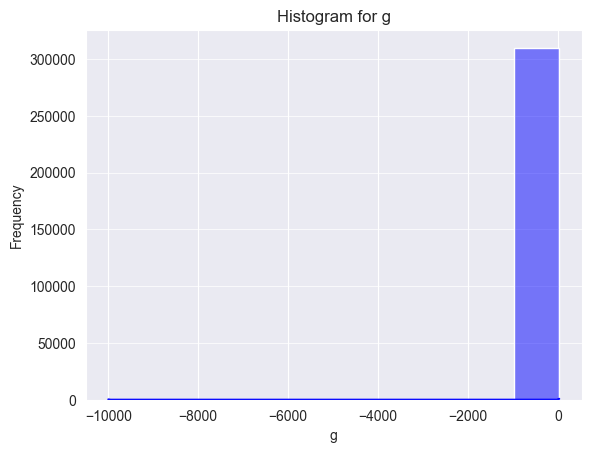

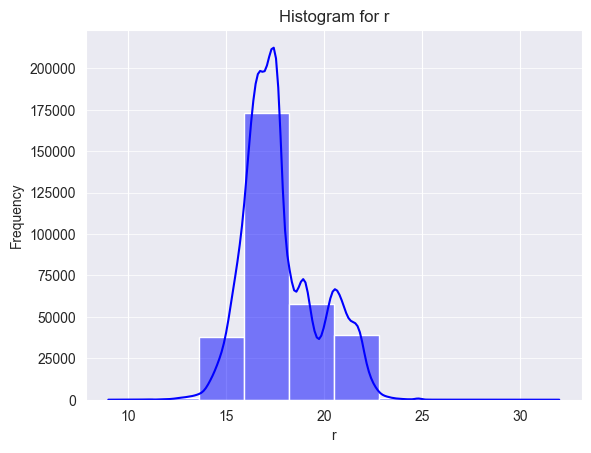

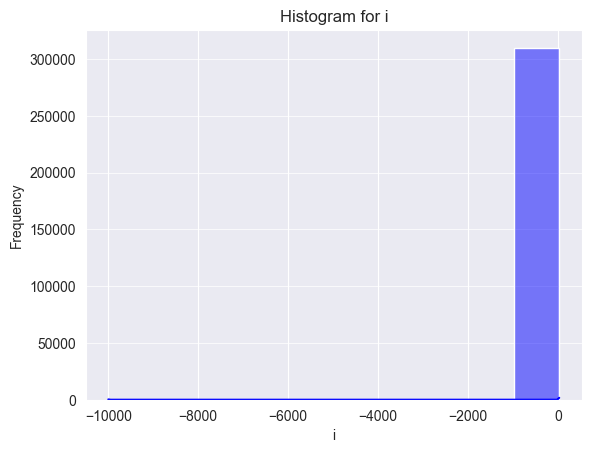

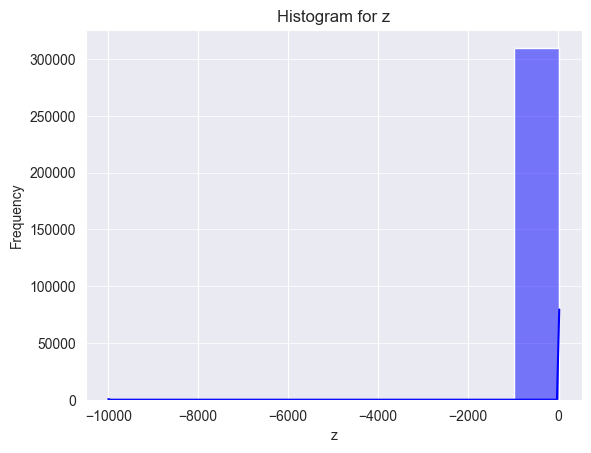

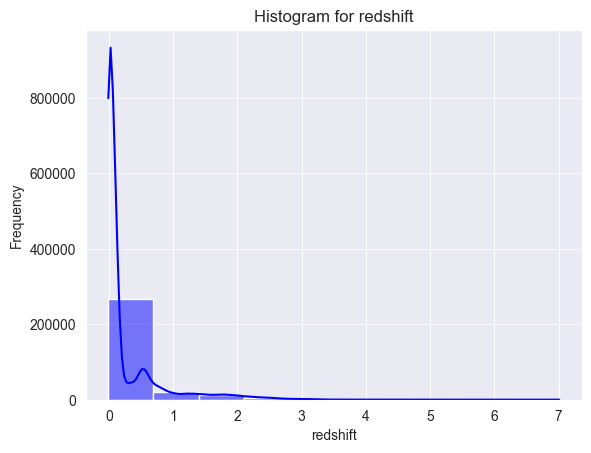

In [272]:
for column in df.select_dtypes(include=['number']).columns:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(df[column], kde=True, bins=10, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Wybieramy zakresy dla poszczególnych kolumn a następnie filtrujemy dane - ryzykujemy utratę niektórych przypadków, ale ewidentnie w zakresie danych są takie które są fizycznie niemożliwe:

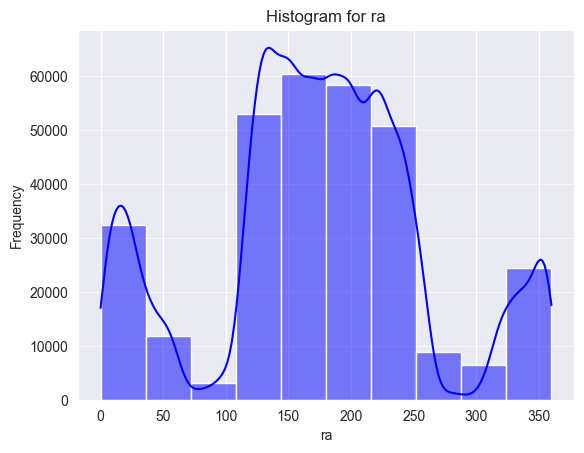

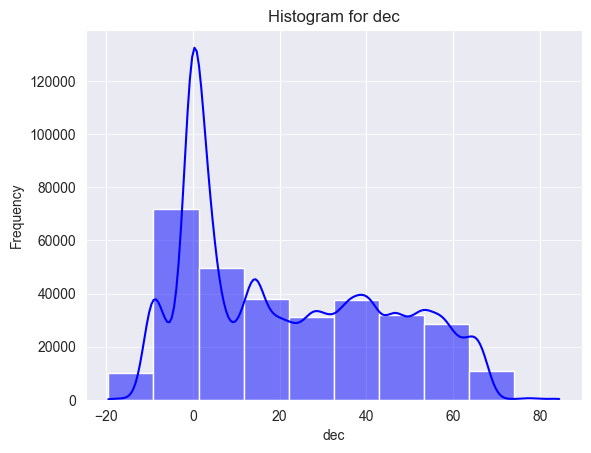

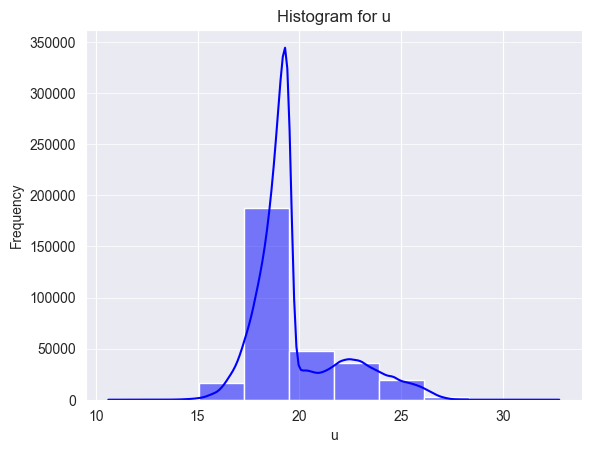

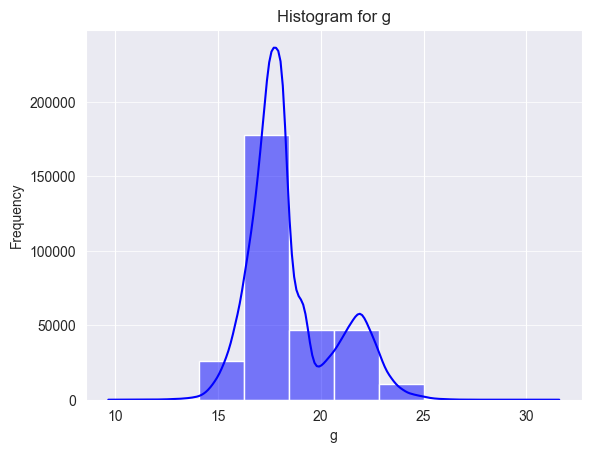

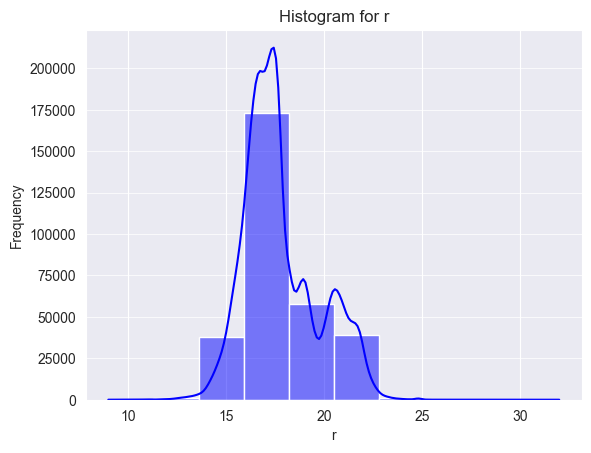

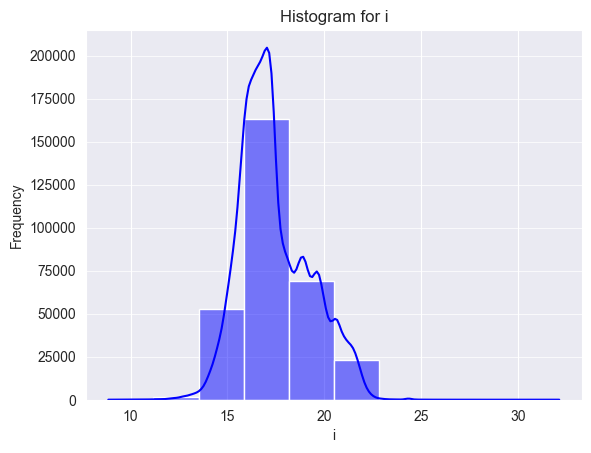

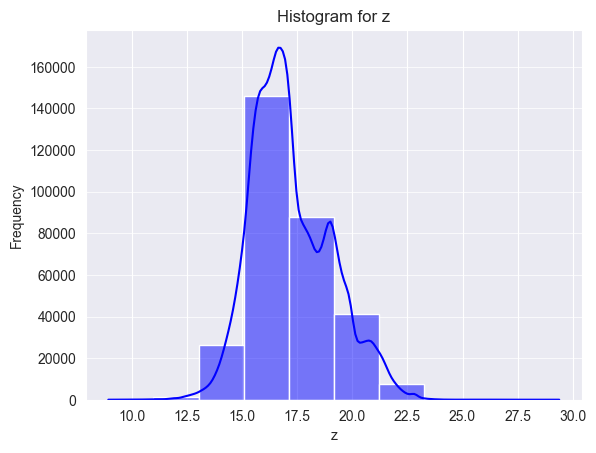

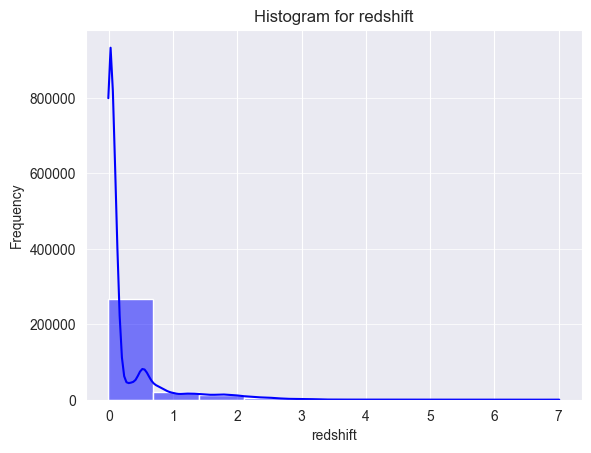

In [273]:
ranges={
"u": (-2000,50),
"g": (-2000,50),
"r": (0,50),
"z": (-2000,50),
}
for column, (min_val, max_val) in ranges.items():
    df = df[(df[column] >= min_val) & (df[column] <= max_val)]
df = df.reset_index(drop=True)

for column in df.select_dtypes(include=['number']).columns:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(df[column], kde=True, bins=10, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Podzielmy dane na dwi oddzielne zestawy:

In [275]:
y=df['class']
x=df.drop('class',axis=1)

Przeprowadzimy teraz 
## Analizę składowych głównych
zaczniemy od standaryzacji zmiennych


In [277]:
numeric_df = x.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

Teraz przejdziemy do właściwej analizy sprawdzimy dwie rzeczy:
- jak liczba składowych wpływa na całkowitą wariancję
- następnie wybierzemy jedną konkretną liczbę składowych głownych i obliczymy składowe główne dla niej
  

Skumulowana wariancja: [0.61301954 0.74765284 0.86279967 0.95484645 0.99312401 0.99754811
 0.99902642 1.        ]


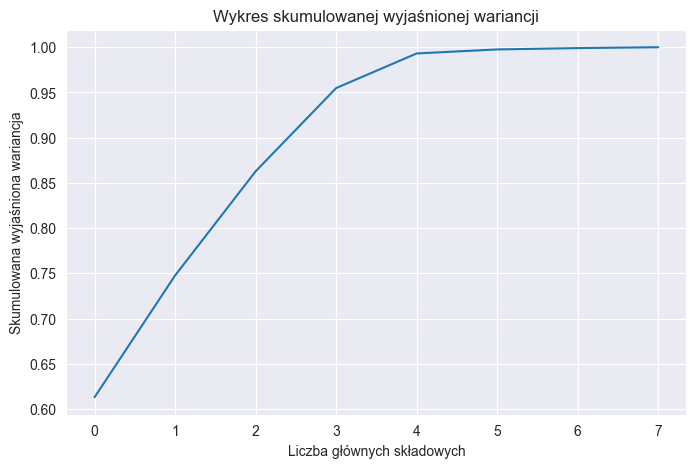

In [278]:
# Tworzenie obiektu PCA, gdzie nie określasz liczby komponentów
pca = PCA()

# Dopasowanie i transformacja danych
pca.fit(scaled_data)

# Sprawdzenie skumulowanej wariancji wyjaśnianej przez kolejne komponenty
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Skumulowana wariancja: {cumulative_variance}")

# Wykres skumulowanej wariancji
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance)
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji')
plt.grid(True)
plt.show()

In [279]:
# Utworzenie obiektu PCA 
n_components=4 #liczba składowych głównych
pca = PCA(n_components)

# Dopasowanie i transformacja danych
principal_components = pca.fit_transform(scaled_data)

# Sprawdzenie ile wariancji wyjaśniają komponenty
explained_variance = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniana przez każdą główną składową: {explained_variance}")

# Utworzenie DataFrame z wynikami analizy PCA (ze zredukowanymi wymiarami)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Uzyskanie macierzy składowych
components = pca.components_

# Tworzenie DataFrame z wynikami
components_df = pd.DataFrame(components, columns=x.select_dtypes(include=[np.number]).columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Wyświetlenie macierzy składowych
print(components_df)

Wariancja wyjaśniana przez każdą główną składową: [0.61301954 0.1346333  0.11514683 0.09204678]
           ra       dec         u         g         r         i         z  \
PC1  0.009132  0.029960  0.393228  0.437499  0.446836  0.440635  0.430594   
PC2  0.712033  0.701017 -0.016387 -0.014054 -0.015194 -0.015238 -0.015914   
PC3 -0.700426  0.707398 -0.050002 -0.026158 -0.011492 -0.002054  0.004495   
PC4  0.045491 -0.085055 -0.357515 -0.198924 -0.076150  0.001872  0.041001   

     redshift  
PC1  0.271574  
PC2  0.020044  
PC3  0.075169  
PC4  0.903230  


Widzimy, że wartość dla ra i dec w pierwszej składowej są bardzo małe, natomiast składowe które je wyjaśniają (2 i 3) bardzo słabo wyjaśniają pozostałe. Sprawdźmy na wszelki wypadek macierz korelacji, bo być może ra i dec są wgl niepotrzebne.

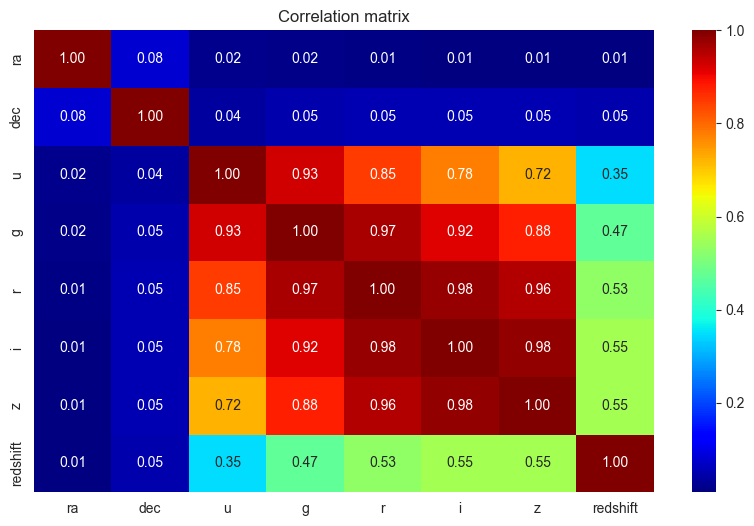

In [280]:
plt.figure(figsize=(10,6))
correlation = pd.concat([x,y],axis=1)
sns.heatmap(x.corr(), annot=True,cmap='jet',fmt='.2f') #jet,copper, coolwarm
plt.title('Correlation matrix')
plt.show()

Wartości ra i dec praktycznie wgl nie pomagają nam w klasyfikacji, pozbędziemy się ich i jeszcz raz ustalimy składowe główne.

Skumulowana wariancja: [0.81672772 0.93976303 0.99083011 0.99673048 0.99870185 1.        ]


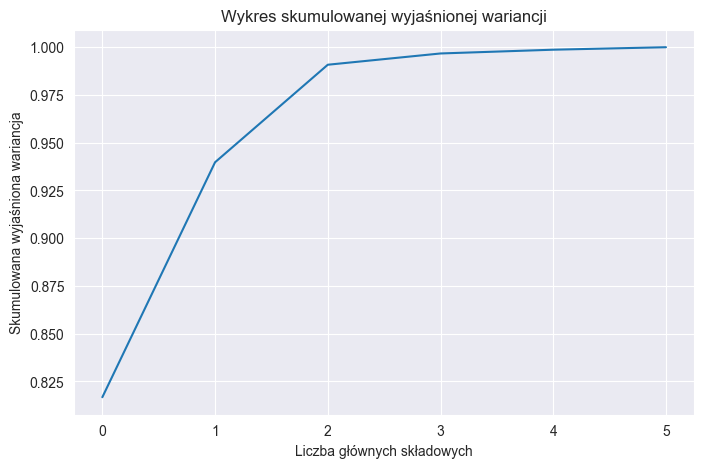

In [282]:
x=x.loc[:, x.columns != 'ra']
x=x.loc[:, x.columns != 'dec']
numeric_df = x.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
# Tworzenie obiektu PCA, gdzie nie określasz liczby komponentów
pca = PCA()

# Dopasowanie i transformacja danych
pca.fit(scaled_data)

# Sprawdzenie skumulowanej wariancji wyjaśnianej przez kolejne komponenty
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Skumulowana wariancja: {cumulative_variance}")

# Wykres skumulowanej wariancji
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance)
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji')
plt.grid(True)
plt.show()

In [283]:
# Utworzenie obiektu PCA 
n_components=2 #liczba składowych głównych
pca = PCA(n_components)

# Dopasowanie i transformacja danych
principal_components = pca.fit_transform(scaled_data)

# Sprawdzenie ile wariancji wyjaśniają komponenty
explained_variance = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniana przez każdą główną składową: {explained_variance}")

# Utworzenie DataFrame z wynikami analizy PCA (ze zredukowanymi wymiarami)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Uzyskanie macierzy składowych
components = pca.components_

# Tworzenie DataFrame z wynikami
components_df = pd.DataFrame(components, columns=x.select_dtypes(include=[np.number]).columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Wyświetlenie macierzy składowych
print(components_df)

Wariancja wyjaśniana przez każdą główną składową: [0.81672772 0.12303531]
            u         g         r         i         z  redshift
PC1  0.393470  0.437721  0.447063  0.440858  0.430811  0.271593
PC2 -0.361179 -0.200761 -0.077152  0.001429  0.041021  0.906426


In [284]:
PCA_values =   x.values @ components_df.T.values
df_PCA_x = pd.DataFrame(PCA_values,columns=[f'PC{i+1}' for i in range(components.shape[0])])
#df_PCA=pd.concat([df_PCA_x,y],axis=1)
df_PCA = df_PCA_x
df_PCA['class'] = pd.DataFrame(y)
df_PCA
df_PCA

,PC1,PC2,class
0,35.645608,-11.038692,0
1,36.664800,-10.787298,0
2,38.206279,-11.175851,1
3,35.380231,-10.321350,0
4,35.829161,-10.166418,0
...,...,...,...
309991,39.278134,-11.324122,0
309992,38.765651,-11.136801,0
309993,36.659873,-10.908642,1
309994,35.120367,-10.100886,0


<Axes: xlabel='PC1', ylabel='PC2'>

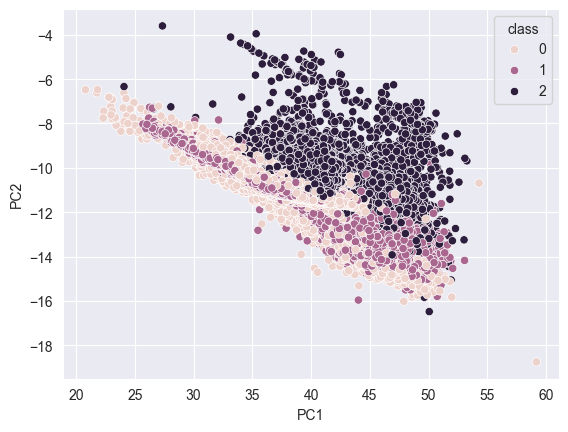

In [289]:
sns.scatterplot(x='PC1',y='PC2',hue='class',data=df_PCA)

<h2 align = 'center'> Klasteryzacja </h2>
<h3 align = 'center'> KMeans </h3>

Normalizacja danych - przygotowanie do klasteryzacji

In [290]:
df_class = df['class']
df = df.drop('class',axis=1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
df['class'] = df_class

Klasteryzacja z użyciem KMeans

In [291]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df['Cluster'] = clusters

Metoda łokcia

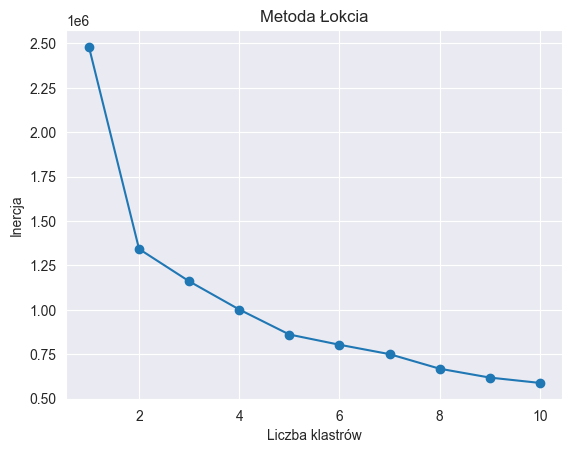

In [292]:
inertias = []
for k in range(1, 11):
    kmeans_ml = KMeans(n_clusters=k, random_state=42)
    kmeans_ml.fit(data_scaled)
    inertias.append(kmeans_ml.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title("Metoda Łokcia")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inercja")
plt.show()


In [293]:
df.groupby('Cluster').mean()

,ra,dec,u,g,r,i,z,redshift,class
Cluster,,,,,,,,,
0,176.872015,24.617398,22.842321,21.575674,20.598721,19.990958,19.663840,0.892420,1.196258
1,170.730654,19.173954,18.199397,16.663351,15.988618,15.676159,15.462196,0.044983,0.618286
2,176.855472,23.161519,19.287995,18.165989,17.666329,17.418949,17.279495,0.175697,0.740211


In [294]:
df['Cluster'].value_counts()

Cluster
2    126641
1    109590
0     73765
Name: count, dtype: int64

In [295]:
df['class'].value_counts()

class
1    168107
0    101072
2     40817
Name: count, dtype: int64

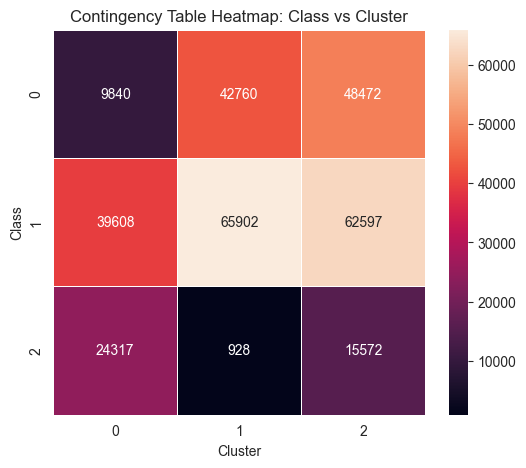

In [317]:
plt.figure(figsize=(6, 5))
sns.heatmap(pd.crosstab(df['class'], df['Cluster']), annot=True, linewidths=0.5, fmt='d')
plt.title("Contingency Table Heatmap: Class vs Cluster")
plt.ylabel("Class")
plt.xlabel("Cluster")
plt.show()

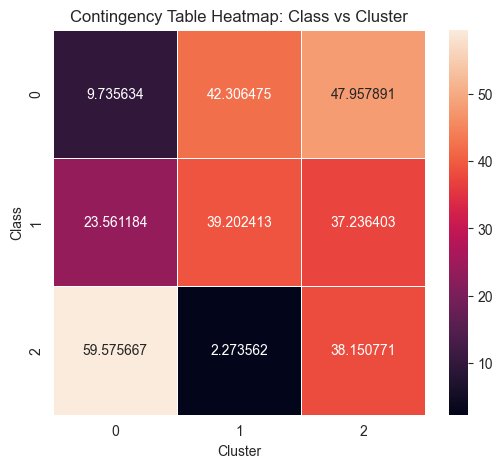

In [324]:
contingency_table = pd.crosstab(df['class'], df['Cluster'])
contingency_percentage =  contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
plt.figure(figsize=(6, 5))
sns.heatmap(contingency_percentage, annot=True, linewidths=0.5, fmt='f')
plt.title("Contingency Table Heatmap: Class vs Cluster")
plt.ylabel("Class")
plt.xlabel("Cluster")
plt.show()

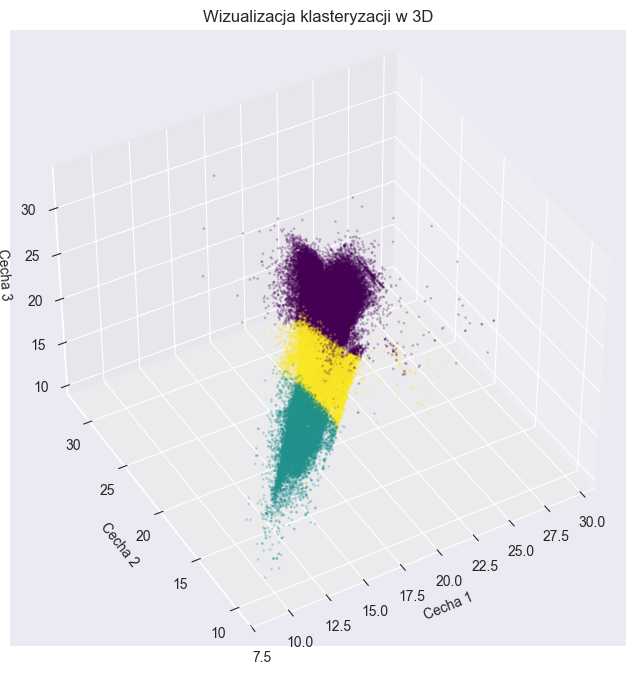

In [316]:
feature_1 = df['z']
feature_2 = df['g']
feature_3 = df['u']
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_1, feature_2, feature_3, c=clusters, cmap='viridis', s=1, alpha=0.2)
ax.set_title("Wizualizacja klasteryzacji w 3D")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.set_zlabel("Cecha 3")
ax.view_init(elev=40, azim=240)
ax.grid(True)
plt.show()

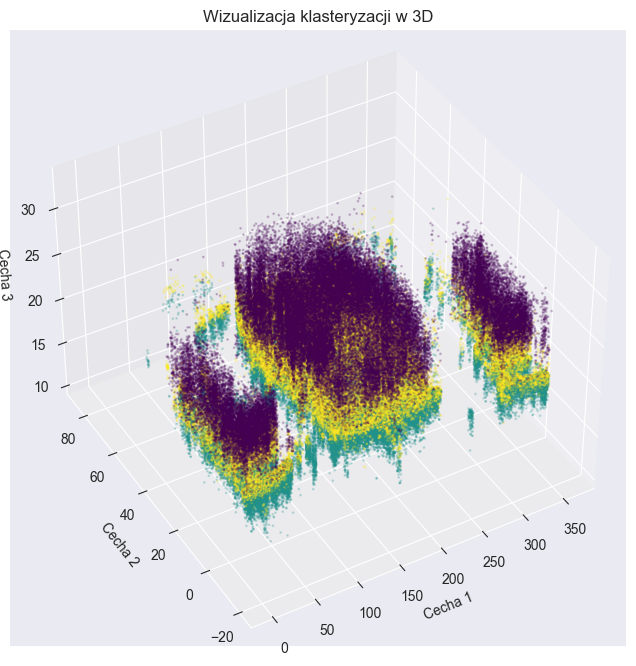

In [297]:
feature_1 = df['ra']
feature_2 = df['dec']
feature_3 = df['u']
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_1, feature_2, feature_3, c=clusters, cmap='viridis', s=1, alpha=0.2)
ax.set_title("Wizualizacja klasteryzacji w 3D")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.set_zlabel("Cecha 3")
ax.view_init(elev=40, azim=240)
ax.grid(True)
plt.show()

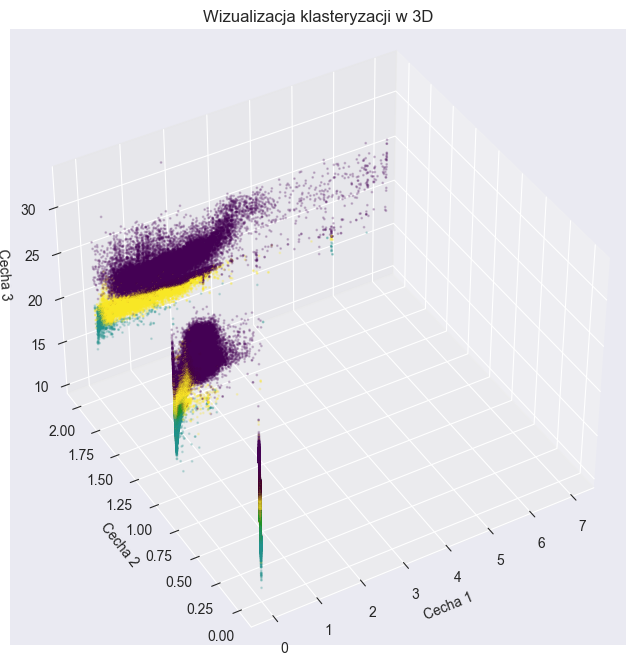

In [298]:
feature_1 = df['redshift']
feature_2 = df['class']
feature_3 = df['u']
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_1, feature_2, feature_3, c=clusters, cmap='viridis', s=1, alpha=0.2)
ax.set_title("Wizualizacja klasteryzacji w 3D")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.set_zlabel("Cecha 3")
ax.view_init(elev=40, azim=240)
ax.grid(True)
plt.show()

<h3 align = 'center'> KMeans na PCA </h3>

In [299]:
scaler_pca = StandardScaler()
df_PCA_class = df_PCA['class']
df_PCA = df_PCA.drop('class',axis=1)
data_scaled_pca = scaler.fit_transform(df_PCA)
df_PCA['class'] = df_PCA_class
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(data_scaled_pca)
df_PCA['Cluster'] = clusters_pca

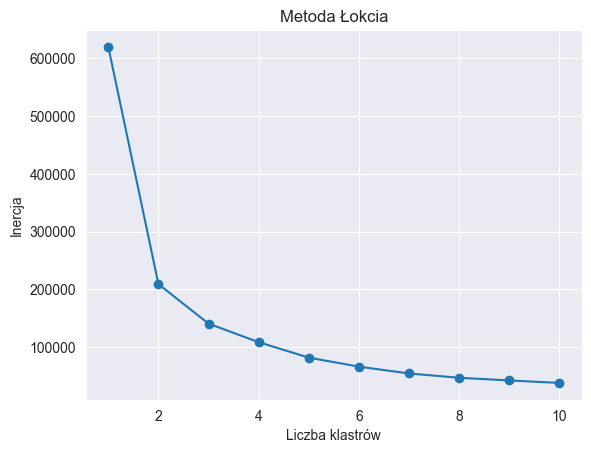

In [303]:
inertias = []
for k in range(1, 11):
    kmeans_ml = KMeans(n_clusters=k, random_state=42)
    kmeans_ml.fit(data_scaled_pca)
    inertias.append(kmeans_ml.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title("Metoda Łokcia")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inercja")
plt.show()

In [304]:
cluster_summary = df_PCA.groupby('Cluster').mean()
print(cluster_summary)

               PC1        PC2     class
Cluster                                
0        45.512034 -13.098932  0.974886
1        38.619602 -10.988799  0.854203
2        34.834026 -10.239338  0.587558


In [305]:
print(df_PCA['Cluster'].value_counts())


Cluster
1    163927
2     84390
0     61679
Name: count, dtype: int64


In [306]:
print(df_PCA['class'].value_counts())

class
1    168107
0    101072
2     40817
Name: count, dtype: int64


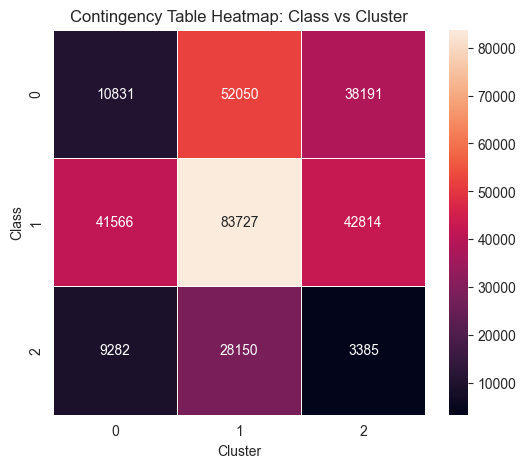

In [325]:
plt.figure(figsize=(6, 5))
sns.heatmap(pd.crosstab(df_PCA['class'], df_PCA['Cluster']), annot=True, linewidths=0.5, fmt='d')
plt.title("Contingency Table Heatmap: Class vs Cluster")
plt.ylabel("Class")
plt.xlabel("Cluster")
plt.show()

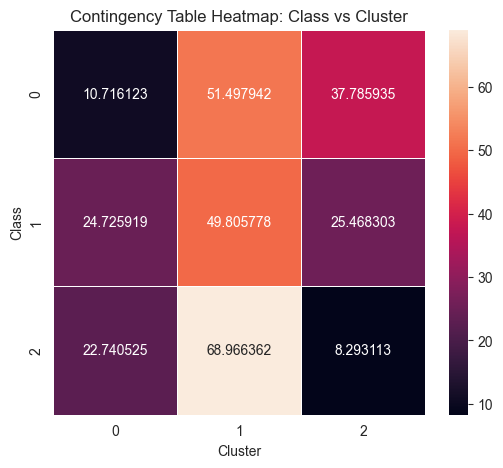

In [326]:
contingency_table = pd.crosstab(df_PCA['class'], df_PCA['Cluster'])
contingency_percentage =  contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
plt.figure(figsize=(6, 5))
sns.heatmap(contingency_percentage, annot=True, linewidths=0.5, fmt='f')
plt.title("Contingency Table Heatmap: Class vs Cluster")
plt.ylabel("Class")
plt.xlabel("Cluster")
plt.show()

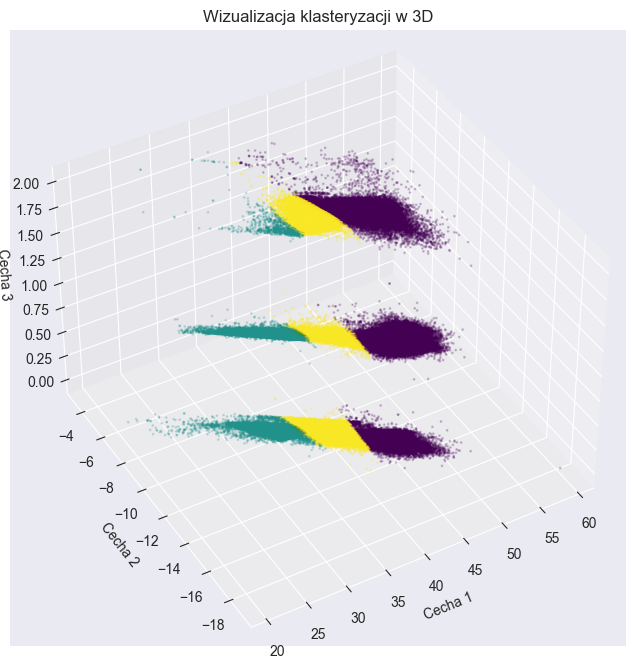

In [307]:
feature_1 = df_PCA['PC1']
feature_2 = df_PCA['PC2']
feature_3 = df_PCA['class']
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_1, feature_2, feature_3, c=clusters, cmap='viridis', s=1, alpha=0.2)
ax.set_title("Wizualizacja klasteryzacji w 3D")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.set_zlabel("Cecha 3")
ax.view_init(elev=40, azim=240)
ax.grid(True)
plt.show()

# Naprawiłem błąd z y btw